In [1]:
import requests
from PIL import Image
import torch
import numpy

from transformers import EomtForUniversalSegmentation, AutoImageProcessor


model_id = "tue-mps/coco_panoptic_eomt_large_640"
processor = AutoImageProcessor.from_pretrained(model_id)
model = EomtForUniversalSegmentation.from_pretrained(model_id)

/Users/michaliskaseris/Documents/dev/content-awareness/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_device():
    """Get the best available device (CUDA, MPS, or CPU)"""
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

In [3]:
input_image = "/Users/michaliskaseris/Documents/dev/content-awareness/Cat.jpg"
image = Image.open(input_image)

device = get_device()

model = model.to(device)



In [4]:
inputs = processor(
        images=image,
        return_tensors="pt",
    )

inputs = {k: v.to(device) if hasattr(v, 'to') else v for k, v in inputs.items()}
    
with torch.inference_mode():
    outputs = model(**inputs)

/var/folders/pd/yqgbd94x65v5dx7hqt255bj80000gn/T/ipykernel_44259/639429030.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap('viridis', torch.max(segmentation))


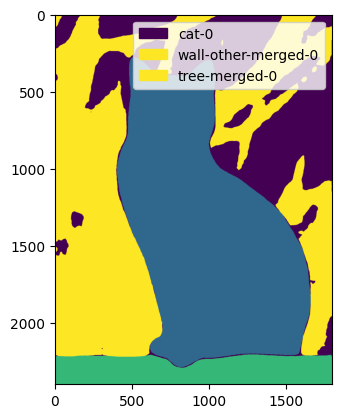

In [6]:
predictions = processor.post_process_panoptic_segmentation(
    outputs,
    target_sizes=[(image.height, image.width)],
)

from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm

def draw_panoptic_segmentation(segmentation, segments_info):
    # get the used color map
    viridis = cm.get_cmap('viridis', torch.max(segmentation))
    fig, ax = plt.subplots()
    ax.imshow(segmentation)
    instances_counter = defaultdict(int)
    handles = []
    # for each segment, draw its legend
    for segment in segments_info:
        segment_id = segment['id']
        segment_label_id = segment['label_id']
        segment_label = model.config.id2label[segment_label_id]
        label = f"{segment_label}-{instances_counter[segment_label_id]}"
        instances_counter[segment_label_id] += 1
        color = viridis(segment_id)
        handles.append(mpatches.Patch(color=color, label=label))
        
    ax.legend(handles=handles)


draw_panoptic_segmentation(predictions[0]["segmentation"].cpu(), predictions[0]["segments_info"])


In [ ]:
predictions[0]